# Final Project - A/B Testing

# The goals of the study


The goal of this project is to complete an a/b test that was previously started.   

**Technical description**  

•	Test name: recommender_system_test  
•	Groups: А (control), B (new payment funnel)  
•	Launch date: 2020-12-07  
•	Date when they stopped taking up new users: 2020-12-21  
•	End date: 2021-01-01  
•	Audience: 15% of the new users from the EU region   
•	Purpose of the test: testing changes related to the introduction of an improved recommendation system  
•	Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.  
•	Expected number of test participants: 6000  

**Data Sources**  

•	ab_project_marketing_events_us.csv — the calendar of marketing events for 2020   
•	final_ab_new_users_upd_us.csv — all users who signed up in the online store from December 7 to 21, 2020  
•	final_ab_events_upd_us.csv — all events of the new users within the period from December 7, 2020 through January 1, 2020  
•	final_ab_participants_upd_us.csv — table containing test participants   

**Structure of ab_project__marketing_events_us.csv:**  
•	name — the name of the marketing event  
•	regions — regions where the ad campaign will be held  
•	start_dt — campaign start date  
•	finish_dt — campaign end date   

**Structure of final_ab_new_users_upd_us.csv:**  
•	user_id  
•	first_date — sign-up date  
•	region  
•	device — device used to sign up  

**Structure of final_ab_events_upd_us.csv:**  
•	user_id  
•	event_dt — event date and time  
•	event_name — event type name  
•	details — additional data on the event (for instance, the order total in USD for purchase events)  

**Structure of final_ab_participants_upd_us.csv:**  
•	user_id  
•	ab_test — test name  
•	group — the test group the user belonged to

In [1]:
!pip install sidetable

In [2]:
!pip install plotly

In [3]:
#Downloading relevant libraries
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 210
from datetime import datetime
import scipy.stats as stats
import datetime as dt
import sidetable
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import seaborn
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings(action='ignore')

## Downloading, reading, and studying the data

### Details on marketing events

In [4]:
#downloading and reading the data
marketing_events=pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


### Details on new store users

In [5]:
#downloading and reading the data
new_users=pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
#studying the missing values and data types
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [7]:
#lookin for missing values
new_users.stb.missing(style=True)

,missing,total,percent
user_id,0,"58,703",0.00%
first_date,0,"58,703",0.00%
region,0,"58,703",0.00%
device,0,"58,703",0.00%


In [8]:
#looking for duplicates
new_users[new_users.duplicated()]

,user_id,first_date,region,device


In [9]:
#Converting the date to datetime format
new_users['first_date']=pd.to_datetime(new_users['first_date'],format='%Y-%m-%d')
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [10]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [11]:
#Lookinf at device unique values and numbers
new_users.device.value_counts()

Android    26159
PC         14845
iPhone     11902
Mac         5797
Name: device, dtype: int64

In [12]:
#The devices in % of the total
new_users.device.value_counts(normalize=True)

Android    0.445616
PC         0.252883
iPhone     0.202749
Mac        0.098751
Name: device, dtype: float64

The users mostly come to the store from their cell phones.

In [13]:
#Looking at region destribution
new_users.region.value_counts(normalize=True)

EU           0.739247
N.America    0.154183
CIS          0.053319
APAC         0.053251
Name: region, dtype: float64

The vast majority of users (74%) come from EU.

In [14]:
#Total number of users
new_users.user_id.nunique()

58703

There're about 59,000 users who have logged for the first time between December 7 to 21, 2020.

In [15]:
new_users['first_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-23
Name: first_date, dtype: datetime64[ns]

'first_date' column has wrong datatype and has been converted into datetime format.

### Details on new store users' events

In [16]:
#downloading and reading the data
new_users_events=pd.read_csv('/datasets/final_ab_events_upd_us.csv')
new_users_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [17]:
#studying the missing values and data types
new_users_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [18]:
#looking for missing values
new_users_events.stb.missing(style=True)

,missing,total,percent
details,"363,447","423,761",85.77%
user_id,0,"423,761",0.00%
event_dt,0,"423,761",0.00%
event_name,0,"423,761",0.00%


In the details column, about 86% of the values are missing. This is expected, as per tech description, details columns includes additional data on the event (for instance, the order total in USD for purchase events). It's possible that not all of the events included an additional data. We will leave this column as is.

In [19]:
#lookimg for duplicates
new_users_events[new_users_events.duplicated()]

,user_id,event_dt,event_name,details


In [20]:
#Number of users in the events dataset
new_users_events.user_id.nunique()

58703

In [21]:
#Let's look at the events and their destribution by the number of values
new_users_events['event_name'].value_counts()

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64

In [22]:
new_users_events['event_dt'].agg({'min', 'max'})

min    2020-12-07 00:00:33
max    2020-12-30 23:36:33
Name: event_dt, dtype: object

In [23]:
new_users_events['event_dt'] = pd.to_datetime(new_users_events['event_dt'], format='%Y-%m-%d')

Despite the fact, that the technical specs state that the dataset final_ab_events_upd_us includes all events of the new users within the period from December 7, 2020 through January 1, 2021, in the dataset we have events only until December 30. Something must have happened past that date and should be clarified with the data engineers. No wonder that the previous data analyst quit to start a watermelon farm in Brazil. She should never come back to the business.

In [24]:
#Converting the date column into datetime format
new_users_events['event_date']  = new_users_events['event_dt'].dt.date
new_users_events['event_date'] = pd.to_datetime(new_users_events['event_date'])
new_users_events.head()

,user_id,event_dt,event_name,details,event_date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


**Average number of events per user**

In [25]:
new_users_events.groupby(['user_id'])['event_name'].count().reset_index()

,user_id,event_name
0,0001710F4DDB1D1B,6
1,000199F1887AE5E6,16
2,0002499E372175C7,9
3,0002CE61FF2C4011,12
4,000456437D0EFFE1,4
...,...,...
58698,FFF7A7BAF44FE9B4,2
58699,FFF8FDBE2FE99C91,12
58700,FFF91B6C5431F375,8
58701,FFFAB034A09DCC28,4


In [26]:
#Let's look at the destribution of the number of events per user
new_users_events.groupby(['user_id'])['event_name'].count().reset_index()['event_name'].describe()

count    58703.000000
mean         7.218728
std          4.122609
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         36.000000
Name: event_name, dtype: float64

On evarage, in the general dataset the users performed 7 events. 50% of users performed 6 events or less. Some users performed 36 events.

Let's see how many users performed each of the events.

In [27]:
new_users_events.groupby(['user_id'])['event_name'].nunique().reset_index()['event_name'].value_counts()

2    25682
3    19674
1     9099
4     4248
Name: event_name, dtype: int64

Let's see the distribution of events by date. 

**The chart was deleted as it's too heavy for the GitHub**


plt.figure(figsize=(13,6))    
fig = px.histogram(new_users_events, x='event_date', title='Distribution of events by date', labels={'event_date':'Times'})    fig.show();

We can see that number of event starts going up started Dec 10th, and there's a significant spike right before X-mas. After X-mas there's a dramatic drop. The data is missing on Dec 25-26. Either noone shopped or something went wrong during data collection.

### Details on test participants

In [29]:
#downloading and reading the data
test_participants=pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
test_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [30]:
#studying the missing values and data types
test_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [31]:
#looking for missing values
test_participants.stb.missing(style=True)

,missing,total,percent
user_id,0,"14,525",0.00%
group,0,"14,525",0.00%
ab_test,0,"14,525",0.00%


In [32]:
#looking for duplicates
test_participants[test_participants.duplicated()]

,user_id,group,ab_test


In [33]:
test_participants.describe()

,user_id,group,ab_test
count,14525,14525,14525
unique,13638,2,2
top,5EF0009854428FB8,A,interface_eu_test
freq,2,8214,10850


We have a total of 14,525 participants, although per specs we should have 6,000. We also see that there are two tests.

In [34]:
#Let's see which groups we have
test_participants.group.unique()

array(['A', 'B'], dtype=object)

In [35]:
#Let's see the distribution of participants between the groups
test_participants['group'].value_counts()

A    8214
B    6311
Name: group, dtype: int64

In [36]:
#Let's look what tests we have in the dataset
test_participants.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

We have data on two tests in the dataset: 'recommender_system_test' and 'interface_eu_test', whereas we are only interested in 'recommender_system_test'.

In [37]:
#Checing the number of participants for each test
test_participants['ab_test'].value_counts()

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

In [38]:
test_participants.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count')

group,A,B
ab_test,,
interface_eu_test,5467,5383
recommender_system_test,2747,928


The recommender_system_test only has 3,675 participants. They are split into two groups: A with 2747 and B with 928 participants.

## Exploratory data analysis

Let's check for test participants who may belong to both tests.

In [39]:
#checking whether the participants belong to more that one test
test_duplicates = test_participants.groupby(['user_id'])['ab_test'].nunique().sort_values(ascending=False).reset_index()
test_duplicates.head()

,user_id,ab_test
0,83AB3C13B3972BAE,2
1,E0EEE04D9FDB4931,2
2,6786C23A54D59DD4,2
3,21C2D41E1FDF1E70,2
4,21AEB217BA764EAB,2


Let's clean the test participants list and leave only those who were assigned to only one of two groups. Regarding the participants who were assigned to two tests, some participant might have been in test group in recommender_system_test and in control group in the second AB test . This means that the interface changes did not affect him and we can leave him in our recommender system_test. Therefore, we will first select participants who belong to recommender_system_test. 

In [40]:
#leaving only participants who belong to recommender_system_test
clean_test = test_participants.query('ab_test == "recommender_system_test"')
clean_test.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


There're might be participants who belong to test groups (B) in both tests. This means that an interface changes might have effected them. We will make a list of users who belong to the test group in the second test to make sure none of these users were included in the recommender_system_test.

In [41]:
# Making a list of users who belong to the test group in the interface_eu_test
interface_B = test_participants.query('ab_test == "interface_eu_test" and group == "B"')['user_id'].to_list()

Let's check whethere there are user who belong to more than one group in the recommender_system_test.

In [42]:
group_duplicates = clean_test.groupby(['user_id'])['group'].nunique().sort_values(ascending=False).reset_index()
group_duplicates.head()

,user_id,group
0,001064FEAAB631A1,1
1,AAB4D11666ADB943,1
2,AAD72B195EFC73A4,1
3,AAE1914BDB419328,1
4,AAE4A39A0DF719AD,1


There're no such users.

In [43]:
#checking the number of unique users in the test
clean_test['user_id'].nunique()

3675

In [44]:
#excluding users who might have have been in the test group in the second test
clean_test = clean_test[~(clean_test['user_id'].isin(interface_B))]
clean_test.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [45]:
#checking the number of unique users in the test 
clean_test['user_id'].nunique()

3244

As it appears, there were a nummber of user who assigned to two test groups.

In [46]:
#Let's see how many test participants we have left
clean_test.describe()

,user_id,group,ab_test
count,3244,3244,3244
unique,3244,2,1
top,212D88C42A5E6FDB,A,recommender_system_test
freq,1,2422,3244


In [47]:
#Total users for each test
clean_test['ab_test'].value_counts()

recommender_system_test    3244
Name: ab_test, dtype: int64

3,244 participants in 'recommender_system_test' test, despite the fact, that technical specifications state state that there should be 6,000 participants.

In [48]:
#checking the users' distribution by groups
clean_test.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='count')

group,A,B
ab_test,,
recommender_system_test,2422,822


As it is visibale from the data, in 'recommender_system_test' 2,422 participants in group A and only 822 participanst in group B. The test groups weren't equally spit. It seems like technical description doesn't really match any of the tests.   
In this research we will only include users two participated in recommender_system_test test.

### Conversion at different stages of the funnel

In [49]:
#Making a list of users who belong to "recommender_system_test"
system_test_list = clean_test['user_id'].to_list()
#From the new_users dataset - selecting users who belong to "recommender_system_test"
system_test = new_users[(new_users['user_id'].isin(system_test_list))]
system_test

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
19,DD4352CDCF8C3D57,2020-12-07,EU,Android
22,831887FE7F2D6CBA,2020-12-07,EU,Android
38,4CB179C7F847320B,2020-12-07,EU,iPhone
39,29C92313A98B1176,2020-12-07,APAC,Android
...,...,...,...,...
58642,87C4963DF01E3B3C,2020-12-20,EU,Android
58652,3CA972F86411CF13,2020-12-20,EU,PC
58664,0F7D49FC184EDCDE,2020-12-20,EU,PC
58680,574ACBC674BC385D,2020-12-20,EU,Mac


In [50]:
#Merging test users information with new users information
system_test = system_test.merge(clean_test, how='left', on='user_id')
system_test

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
3,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
4,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test
...,...,...,...,...,...,...
3239,87C4963DF01E3B3C,2020-12-20,EU,Android,B,recommender_system_test
3240,3CA972F86411CF13,2020-12-20,EU,PC,A,recommender_system_test
3241,0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test
3242,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test


In [51]:
#From the users' events selecting evenst performed by recommender_system_test test users
system_test_events = new_users_events[(new_users_events['user_id'].isin(system_test_list))]
system_test_events.head()

,user_id,event_dt,event_name,details,event_date
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07


In [52]:
#Studying the number of test users in the events datasel
system_test_events.user_id.nunique()

3244

In [53]:
#Merging all the relevant data on test participants and their behaviour
system_test_all = system_test_events.merge(system_test, how='left', on='user_id')
system_test_all.head()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,EU,iPhone,B,recommender_system_test
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,EU,PC,B,recommender_system_test


In [54]:
#Checing whether the merge has been performed correctly
system_test_all.user_id.nunique()

3244

**Building the funnel:**

In [55]:
#Let's check the events frequency within recommender_system_test participants
events_freq = system_test_events['event_name'].value_counts().sort_values(ascending=False).reset_index()
events_freq

,index,event_name
0,login,9584
1,product_page,5911
2,purchase,2833
3,product_cart,2809


In [56]:
#Let's build the funnel by sorting the events by ppularity
funnel = system_test_all.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False).reset_index()
funnel

,event_name,user_id
0,login,3243
1,product_page,2030
2,purchase,999
3,product_cart,953


About 50% of those who viewed the product page, have made a purchase.

In [57]:
funnel['proportion_to_total_users'] = funnel['user_id']/system_test_events['user_id'].nunique()
funnel

,event_name,user_id,proportion_to_total_users
0,login,3243,0.999692
1,product_page,2030,0.625771
2,purchase,999,0.307953
3,product_cart,953,0.293773


31% of all users have made a purchase.

In [58]:
funnel['conversion_stages']=funnel['user_id'].pct_change()
funnel

,event_name,user_id,proportion_to_total_users,conversion_stages
0,login,3243,0.999692,NaN
1,product_page,2030,0.625771,-0.374036
2,purchase,999,0.307953,-0.507882
3,product_cart,953,0.293773,-0.046046


The largest drop is from product page to purchase (51%).

In [59]:
#Events by group
events_per_group = system_test_all.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
events_per_group

group,event_name,A,B
0,login,2422,821
1,product_cart,728,225
2,product_page,1571,459
3,purchase,773,226


In [60]:
df_mapping = pd.DataFrame({
    'event_name': ['login', 'product_page', 'product_cart', 'purchase'],
})
sort_mapping = df_mapping.reset_index().set_index('event_name')
events_per_group['event_name_num'] = events_per_group['event_name'].map(sort_mapping['index'])
events_per_group.sort_values('event_name_num')

group,event_name,A,B,event_name_num
0,login,2422,821,0
2,product_page,1571,459,1
1,product_cart,728,225,2
3,purchase,773,226,3


In [61]:
df_mapping_all = pd.DataFrame({
    'event_name': ['login', 'product_page', 'product_cart', 'purchase'],
})
sort_mapping = df_mapping.reset_index().set_index('event_name')
system_test_all['event_name_num'] = system_test_all['event_name'].map(sort_mapping['index'])
system_test_all.sort_values('event_name_num').head()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test,event_name_num
21136,75845C83258FBF73,2020-12-30 06:42:52,login,NaN,2020-12-30,2020-12-07,EU,Android,B,recommender_system_test,0
14748,B1558ECC094DB48D,2020-12-16 16:37:46,login,NaN,2020-12-16,2020-12-16,EU,Android,A,recommender_system_test,0
14747,7B8E8C3A8DAFC3B3,2020-12-16 06:28:43,login,NaN,2020-12-16,2020-12-16,EU,PC,B,recommender_system_test,0
14746,9D263B8EF15CF188,2020-12-16 15:17:29,login,NaN,2020-12-16,2020-12-16,N.America,Mac,B,recommender_system_test,0
14745,F8317163930006BE,2020-12-16 06:45:44,login,NaN,2020-12-16,2020-12-16,EU,Android,A,recommender_system_test,0


In [62]:
#Building a funnel by group
funnel_by_groups=[]
for i in system_test_all.group.unique():
    group=system_test_all[system_test_all.group==i].groupby(['event_name','group', 'event_name_num'])['user_id'].nunique().reset_index().sort_values(by='event_name_num')
    display(group)
    funnel_by_groups.append(group)

,event_name,group,event_name_num,user_id
0,login,A,0,2422
2,product_page,A,1,1571
1,product_cart,A,2,728
3,purchase,A,3,773


,event_name,group,event_name_num,user_id
0,login,B,0,821
2,product_page,B,1,459
1,product_cart,B,2,225
3,purchase,B,3,226


In [63]:
funnel_by_groups=pd.concat(funnel_by_groups)
funnel_by_groups

,event_name,group,event_name_num,user_id
0,login,A,0,2422
2,product_page,A,1,1571
1,product_cart,A,2,728
3,purchase,A,3,773
0,login,B,0,821
2,product_page,B,1,459
1,product_cart,B,2,225
3,purchase,B,3,226


In [64]:
colors = ["yellow", "yellow", "yellow", "yellow", "purple", "purple", "purple", "purple", "red", "red", "red", "red"]
fig = go.Figure(go.Funnel(y=funnel_by_groups['event_name'], x=funnel_by_groups['user_id'], 
                          textposition="inside", textinfo="value+percent initial", marker = dict(color=colors)))

fig.update_layout(
    title="Event funnel: share of users who made the entire journey from their first event to purchase",
    legend_title="Groups",
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show();

In [65]:
226/821

0.27527405602923266

**In Control group:**   
65% went from login to product page.  
46% of users who saw product page, went to the product cart.
Over 52% of users who saw the product page, have made a purchase. 32% of control group users have made a purchase.

**In Test group:**   
56% went from login to product page.  
49% of those who viewed the product page, went from purchase.  
About 50% of users who saw the product page, have made a purchase. 28% of test group users have made a purchase.

In [66]:
#Aggregating number of events by date and group
system_test_all_cumul = system_test_all.groupby(['event_date', 'group', 'event_name'])['user_id'].nunique().reset_index()
#orders_cumul.columns = ['date', 'group', 'purchases', 'buyers', 'revenue']
system_test_all_cumul.head()

,event_date,group,event_name,user_id
0,2020-12-07,A,login,128
1,2020-12-07,A,product_cart,30
2,2020-12-07,A,product_page,81
3,2020-12-07,A,purchase,37
4,2020-12-07,B,login,146


In [67]:
#creating a pivot table with events as columns
system_test_all_cumul_pivot = system_test_all_cumul.pivot_table(index=('event_date', 'group'), columns='event_name', values='user_id', aggfunc='sum').reset_index()
system_test_all_cumul_pivot.colums = ['event_date', 'group', 'login', 'product_cart', 'product_page', 'purchase']
system_test_all_cumul_pivot.head()

event_name,event_date,group,login,product_cart,product_page,purchase
0,2020-12-07,A,128.0,30.0,81.0,37.0
1,2020-12-07,B,146.0,42.0,95.0,54.0
2,2020-12-08,A,145.0,34.0,99.0,33.0
3,2020-12-08,B,104.0,32.0,55.0,30.0
4,2020-12-09,A,157.0,45.0,96.0,47.0


In [68]:
#let's check the data types in the table 
system_test_all_cumul_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_date    45 non-null     datetime64[ns]
 1   group         45 non-null     object        
 2   login         45 non-null     float64       
 3   product_cart  45 non-null     float64       
 4   product_page  45 non-null     float64       
 5   purchase      44 non-null     float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 2.2+ KB


We see that there're some missing values.

In [69]:
#Filling in missing values with 0.
system_test_all_cumul_pivot = system_test_all_cumul_pivot.fillna(0)
system_test_all_cumul_pivot.head()

event_name,event_date,group,login,product_cart,product_page,purchase
0,2020-12-07,A,128.0,30.0,81.0,37.0
1,2020-12-07,B,146.0,42.0,95.0,54.0
2,2020-12-08,A,145.0,34.0,99.0,33.0
3,2020-12-08,B,104.0,32.0,55.0,30.0
4,2020-12-09,A,157.0,45.0,96.0,47.0


In [70]:
#Changing data types
system_test_all_cumul_pivot['login'] = system_test_all_cumul_pivot['login'].astype(int)
system_test_all_cumul_pivot['product_cart'] = system_test_all_cumul_pivot['product_cart'].astype(int)
system_test_all_cumul_pivot['product_page'] = system_test_all_cumul_pivot['product_page'].astype(int)
system_test_all_cumul_pivot['purchase'] = system_test_all_cumul_pivot['purchase'].astype(int)
system_test_all_cumul_pivot.head()

event_name,event_date,group,login,product_cart,product_page,purchase
0,2020-12-07,A,128,30,81,37
1,2020-12-07,B,146,42,95,54
2,2020-12-08,A,145,34,99,33
3,2020-12-08,B,104,32,55,30
4,2020-12-09,A,157,45,96,47


In [71]:
#Calculating cumulative metrics
system_test_all_cumul_pivot['cumul_login']=system_test_all_cumul_pivot['login'].cumsum()
system_test_all_cumul_pivot['cumul_product_cart']=system_test_all_cumul_pivot['product_cart'].cumsum()
system_test_all_cumul_pivot['cumul_product_page']=system_test_all_cumul_pivot['product_page'].cumsum()
system_test_all_cumul_pivot['cumul_purchase']=system_test_all_cumul_pivot['purchase'].cumsum()
system_test_all_cumul_pivot.head()

event_name,event_date,group,login,product_cart,product_page,purchase,cumul_login,cumul_product_cart,cumul_product_page,cumul_purchase
0,2020-12-07,A,128,30,81,37,128,30,81,37
1,2020-12-07,B,146,42,95,54,274,72,176,91
2,2020-12-08,A,145,34,99,33,419,106,275,124
3,2020-12-08,B,104,32,55,30,523,138,330,154
4,2020-12-09,A,157,45,96,47,680,183,426,201


We will split the data set into two parts - events for group A and group B.

In [72]:
#Selecting events for group A
system_test_A = system_test_all_cumul_pivot.query('group == "A"')
system_test_A.head()

event_name,event_date,group,login,product_cart,product_page,purchase,cumul_login,cumul_product_cart,cumul_product_page,cumul_purchase
0,2020-12-07,A,128,30,81,37,128,30,81,37
2,2020-12-08,A,145,34,99,33,419,106,275,124
4,2020-12-09,A,157,45,96,47,680,183,426,201
6,2020-12-10,A,145,41,85,42,974,264,601,276
8,2020-12-11,A,160,41,88,38,1250,337,751,336


In [73]:
#Selecting events for group B
system_test_B = system_test_all_cumul_pivot.query('group == "B"')
system_test_B.head()

event_name,event_date,group,login,product_cart,product_page,purchase,cumul_login,cumul_product_cart,cumul_product_page,cumul_purchase
1,2020-12-07,B,146,42,95,54,274,72,176,91
3,2020-12-08,B,104,32,55,30,523,138,330,154
5,2020-12-09,B,149,40,90,33,829,223,516,234
7,2020-12-10,B,116,32,62,22,1090,296,663,298
9,2020-12-11,B,77,17,38,12,1327,354,789,348


Since some of the stages aren't obligatory, we can only rely on numbers of users who went from login to purchase, therefore, we'll calculate Conversion_total as conversion from login to purchase.

In [74]:
#Let's calculate the conversion for groups A and B:
system_test_A['conversion_total']=system_test_A['purchase']/system_test_A['login']
system_test_B['conversion_total']=system_test_B['purchase']/system_test_B['login']

In [75]:
system_test_A.head()

event_name,event_date,group,login,product_cart,product_page,purchase,cumul_login,cumul_product_cart,cumul_product_page,cumul_purchase,conversion_total
0,2020-12-07,A,128,30,81,37,128,30,81,37,0.289062
2,2020-12-08,A,145,34,99,33,419,106,275,124,0.227586
4,2020-12-09,A,157,45,96,47,680,183,426,201,0.299363
6,2020-12-10,A,145,41,85,42,974,264,601,276,0.289655
8,2020-12-11,A,160,41,88,38,1250,337,751,336,0.237500


In [76]:
system_test_B.head()

event_name,event_date,group,login,product_cart,product_page,purchase,cumul_login,cumul_product_cart,cumul_product_page,cumul_purchase,conversion_total
1,2020-12-07,B,146,42,95,54,274,72,176,91,0.369863
3,2020-12-08,B,104,32,55,30,523,138,330,154,0.288462
5,2020-12-09,B,149,40,90,33,829,223,516,234,0.221477
7,2020-12-10,B,116,32,62,22,1090,296,663,298,0.189655
9,2020-12-11,B,77,17,38,12,1327,354,789,348,0.155844


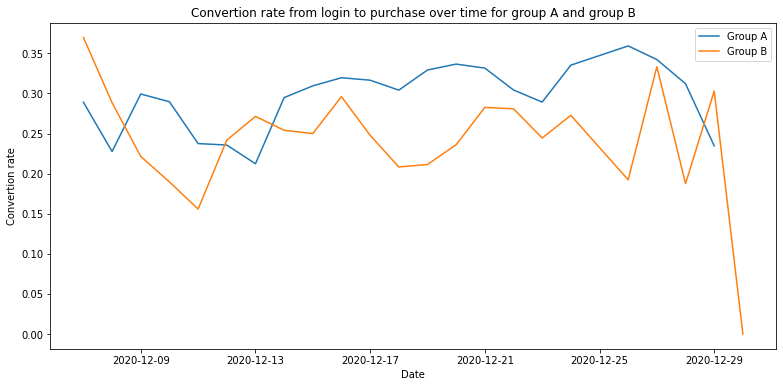

In [77]:
#Plotting the graph for conversion_total
plt.figure(figsize=(13,6))
plt.plot(system_test_A['event_date'], system_test_A['conversion_total'], label='Group A')
plt.plot(system_test_B['event_date'], system_test_B['conversion_total'], label='Group B')
plt.title('Convertion rate from login to purchase over time for group A and group B')
plt.ylabel('Convertion rate')
plt.xlabel('Date')
plt.legend();

The conversion rate fluctuates over time in both groups, whereas, group A (control group) shows slighly better results.

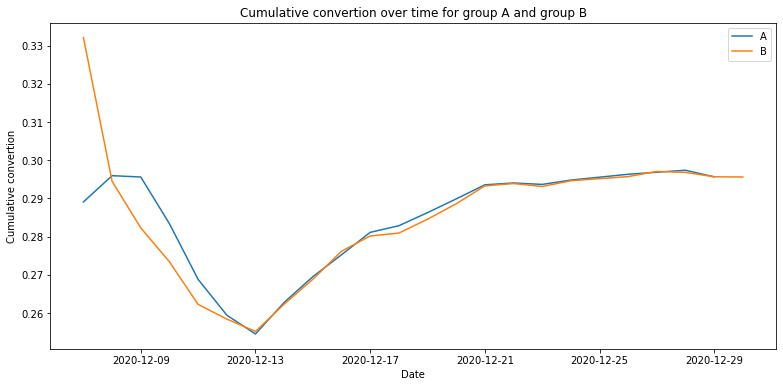

In [78]:
system_test_A['cumul_conversion'] = system_test_A['cumul_purchase']/system_test_A['cumul_login']
system_test_B['cumul_conversion'] = system_test_B['cumul_purchase']/system_test_B['cumul_login']

# plotting the graphs
plt.figure(figsize=(13,6))
plt.plot(system_test_A['event_date'], system_test_A['cumul_conversion'], label='A')
plt.plot(system_test_B['event_date'], system_test_B['cumul_conversion'], label='B')
plt.title('Cumulative convertion over time for group A and group B')
plt.ylabel('Cumulative convertion')
plt.xlabel('Date')
plt.legend();

The cumulative conversion drops by Dec 13th and then rises and stabilizes over time. However, by the end of the test we don't see almost any difference between the groups. The A group is doing slightly better.

In [79]:
#overall conversion Group A:
(system_test_A['purchase'].sum()/system_test_A['login'].sum()).round(3)

0.308

In [80]:
#overall conversion Group B:
(system_test_B['purchase'].sum()/system_test_B['login'].sum()).round(3)

0.254

As we can see, the average conversion rate is better for A group. In fact, the conversion rate drops by 20% for the test group, despite the expected 10% increase.

In [81]:
purchases = system_test_all.query('event_name == "purchase"')
purchases['time_to_purchase'] = purchases['event_date'] - purchases['first_date']
purchases.head()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test,event_name_num,time_to_purchase
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,3,0 days
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test,3,0 days
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,EU,iPhone,B,recommender_system_test,3,0 days
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test,3,0 days
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,EU,PC,B,recommender_system_test,3,0 days


In [82]:
purchases_A = purchases.query('group == "A"')
purchases_A.head()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test,event_name_num,time_to_purchase
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,3,0 days
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test,3,0 days
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test,3,0 days
5,538F954F6B3AECE4,2020-12-07 07:12:05,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,3,0 days
13,DD5EBF41B1DCCB0E,2020-12-07 19:21:29,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test,3,0 days


In [83]:
purchases_A['time_to_purchase'].describe()

count                         2263
mean     2 days 22:27:43.985859478
std      3 days 16:42:23.950187181
min                0 days 00:00:00
25%                0 days 00:00:00
50%                1 days 00:00:00
75%                4 days 00:00:00
max               22 days 00:00:00
Name: time_to_purchase, dtype: object

In [84]:
purchases_B = purchases.query('group == "B"')
purchases.head()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test,event_name_num,time_to_purchase
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,3,0 days
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test,3,0 days
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,EU,iPhone,B,recommender_system_test,3,0 days
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test,3,0 days
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,EU,PC,B,recommender_system_test,3,0 days


In [85]:
purchases_B['time_to_purchase'].describe()

count                          570
mean     3 days 11:19:34.736842105
std      4 days 21:58:46.894151387
min                0 days 00:00:00
25%                0 days 00:00:00
50%                1 days 00:00:00
75%                5 days 00:00:00
max               22 days 00:00:00
Name: time_to_purchase, dtype: object

Based on the analysis above, the average time from from login to purchase increased to 3 days for group B, as opposed to group B - 2 days. In group A 75% of the users make a purchase within 4 days of the login. In group B 75% of the users make a purchase within 5 days of the login.

### Number of events per user

In [86]:
system_events_A = system_test_all.query('group == "A"')
system_events_by_user_A = system_events_A.groupby('user_id')['event_name'].count().reset_index()
system_events_by_user_A.columns = ['user_id', 'events']
system_events_by_user_A.head()

,user_id,events
0,0010A1C096941592,12
1,00341D8401F0F665,2
2,003DF44D7589BBD4,15
3,00505E15A9D81546,5
4,006E3E4E232CE760,6


In [87]:
system_events_B = system_test_all.query('group == "B"')
system_events_by_user_B = system_events_B.groupby('user_id')['event_name'].count().reset_index()
system_events_by_user_B.columns = ['user_id', 'events']
system_events_by_user_B.head()

,user_id,events
0,005E096DBD379BCF,4
1,015D1E3BB893349D,6
2,015FF3EC72C1F4F6,2
3,01B0B891CA513468,12
4,01C17F099908DA14,5


In [88]:
system_events_by_user_A['events'].describe()

count    2422.000000
mean        6.831957
std         3.740697
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: events, dtype: float64

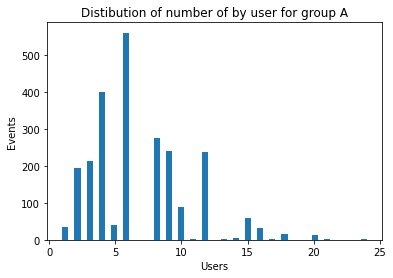

In [89]:
plt.hist(system_events_by_user_A['events'], bins=50)
plt.title('Distibution of number of by user for group A')
plt.ylabel('Events')
plt.xlabel('Users');

In [90]:
system_events_by_user_B['events'].describe()

count    822.000000
mean       5.583942
std        3.387249
min        1.000000
25%        3.000000
50%        4.000000
75%        8.000000
max       28.000000
Name: events, dtype: float64

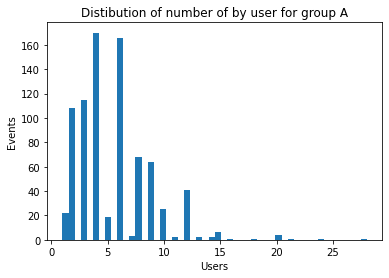

In [91]:
plt.hist(system_events_by_user_B['events'], bins=50)
plt.title('Distibution of number of by user for group A')
plt.ylabel('Events')
plt.xlabel('Users');

In group A there're about 7 events per user on average, the median is 6 events. 75% of the user performed 9 events or less.   
In group B there're 5.6 events per user on average, the median is 4 events. 75% of the user performed 8 events or less. Let's plot a scatter chart with the number of events per user for each group.

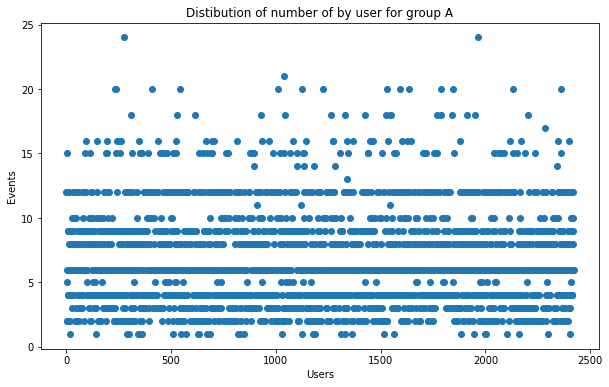

In [92]:
plt.figure(figsize=(10,6))
x_values = pd.Series(range(0,len(system_events_by_user_A)))
plt.scatter(x_values, system_events_by_user_A['events'])
plt.title('Distibution of number of by user for group A')
plt.ylabel('Events')
plt.xlabel('Users');

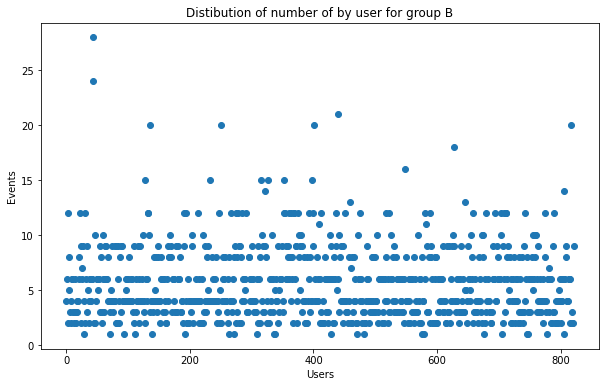

In [93]:
plt.figure(figsize=(10,6))
x_values = pd.Series(range(0,len(system_events_by_user_B)))
plt.scatter(x_values, system_events_by_user_B['events'])
plt.title('Distibution of number of by user for group B')
plt.ylabel('Events')
plt.xlabel('Users');

We see from the data and from visualization that test participants in group A performed more events, comparing to participants in group B.

### Number of events over time

In [94]:
system_events_by_day = system_test_all.groupby('event_date')['user_id'].count().reset_index()
system_events_by_day.columns = ['event_date', 'events']
system_events_by_day.head()

,event_date,events
0,2020-12-07,613
1,2020-12-08,532
2,2020-12-09,657
3,2020-12-10,545
4,2020-12-11,471


In [95]:
system_events_by_day_A = system_events_A.groupby('event_date')['user_id'].count().reset_index()
system_events_by_day_A.columns = ['event_date', 'events']
system_events_by_day_A.head()

,event_date,events
0,2020-12-07,276
1,2020-12-08,311
2,2020-12-09,345
3,2020-12-10,313
4,2020-12-11,327


In [96]:
system_events_by_day_B = system_events_B.groupby('event_date')['user_id'].count().reset_index()
system_events_by_day_B.columns = ['event_date', 'events']
system_events_by_day_B.head()

,event_date,events
0,2020-12-07,337
1,2020-12-08,221
2,2020-12-09,312
3,2020-12-10,232
4,2020-12-11,144


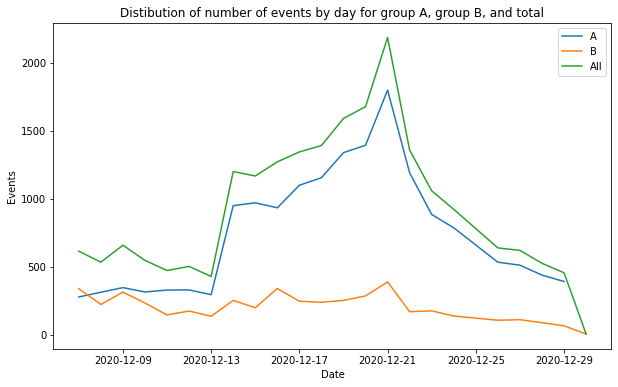

In [97]:
# plotting the graphs
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(system_events_by_day_A['event_date'], system_events_by_day_A['events'], label='A')
plt.plot(system_events_by_day_B['event_date'], system_events_by_day_B['events'], label='B')
plt.plot(system_events_by_day['event_date'], system_events_by_day['events'], label='All')
plt.title('Distibution of number of events by day for group A, group B, and total')
plt.ylabel('Events')
plt.xlabel('Date')
plt.legend();

We see that there's an increase in the number of events starting from Dec 13 all the way to Dec 22, when there's a drastic drop. Interestingly, only the control group shows a significant increase in the number of events during that period, but not the test group.

### Data peculiarities that one has to take into account before starting the A/B test

**Before starting an A/B test, we should run an A/A test to make sure that:**  
•	The results are not affected by anomalies or outliers in the statistical population  
•	The tool for splitting traffic works correctly  
•	Data is sent to analytical systems correctly

**The successful A/A test:**   
•	The number of users in different groups doesn't vary by more than 1%   
•	For all groups, data on the same event is recorded and sent to analytical systems  
•	None of the key metrics varies by a statistically significant amount—typically by no more than 1%  
•	Users remain within their groups until the end of the test. If they see different versions of the page during the study, it won't be clear which version influenced their decisions, so the reliability of the results will be compromised.

Additionnaly, before starting the A/B test, we should check if there are any marketing campaign scheduled during the AB test. 
Let's check if there was any marketing campaign during our AB test.

In [98]:
#Checking the regions
system_test_all.region.unique()

array(['EU', 'N.America', 'CIS', 'APAC'], dtype=object)

In [99]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


We see that during December 2020 there were two marketing campaigns:  
- CIS New Year Gift Lottery Between 2020-12-30 and 2021-01-07 - relevant for the regions of the test.  
- Christmas&New Year Promo in EU, N.America between 2020-12-25 and 2021-01-03. 
We see that there are marketing campaigns between Dec 25 and January 01 - dates relevant for the test frame.
Let's check these dates in the test dataset.

In [100]:
#checking the first login dates
system_test_all['first_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-21
Name: first_date, dtype: datetime64[ns]

From the first glance, it seems as the user logins were performed between Dec 07 and Dec 21, which is before the campaigns started. Therefore, we can conclude that they weren't effected by the campaigns.

In [101]:
#checking all events' dates
system_test_all['event_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-30
Name: event_date, dtype: datetime64[ns]

In [102]:
#checking purchase events dates
system_test_all.query('event_name == "purchase"')['event_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-29
Name: event_date, dtype: datetime64[ns]

In [103]:
#checking product page views dates
system_test_all.query('event_name == "product_page"')['event_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-30
Name: event_date, dtype: datetime64[ns]

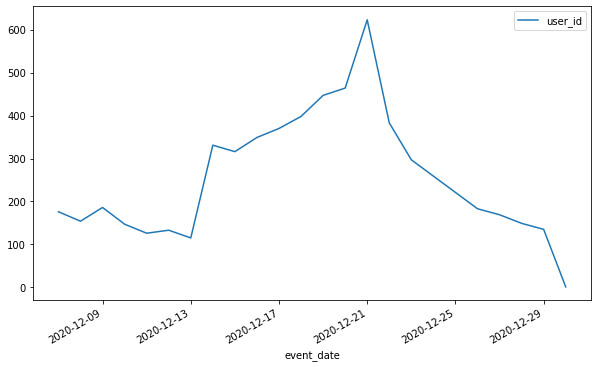

In [104]:
#checking distribution of product page views over time
system_test_all.query('event_name == "product_page"').pivot_table(index='event_date', values='user_id', aggfunc='count').plot();

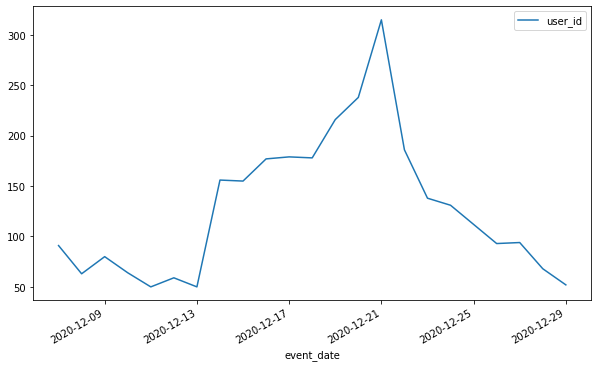

In [105]:
#checking distribution of purchases over time
system_test_all.query('event_name == "purchase"').pivot_table(index='event_date', values='user_id', aggfunc='count').plot();

It looks like the peack of the product_page views and well as the purchases was on Dec 21, which is before the beginning of the campaigns. The impact of the marketing campaigns is not evident. 

In [106]:
#checking purchase events dates in N.America
system_test_all.query('event_name == "purchase" and region == "N.America"')['event_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-28
Name: event_date, dtype: datetime64[ns]

In [107]:
#checking purchase events dates in EU
system_test_all.query('event_name == "purchase" and region == "EU"')['event_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-29
Name: event_date, dtype: datetime64[ns]

In [108]:
#checking purchase events dates in CIS
system_test_all.query('event_name == "purchase" and region == "CIS"')['event_date'].agg({'min', 'max'})

min   2020-12-07
max   2020-12-22
Name: event_date, dtype: datetime64[ns]

On the other hand, the puchase dates overlap with the campaign dates and might have been impacted by the X-mas campaign in EU and N.America. We can't conclude that the A/B test results weren't impacted by the marketing campaigns.

## The A/B test results evaluation

### Summary of the A/B test results

**Funnel results:**  

•	**In Control group:**
- 65% went from login to product page.
- 47.9% of those went from product page to purchase.
- It seems that all of the user who put the product in the cart, made a purchase.  

•	**In Test group:**
- 56% went from login to product page.
- 49.9% of those went from product page to purchase.
- It seems that all of the user who put the product in the cart, made a purchase.   

•	Since some of the stages weren’t obligatory, we can only rely on numbers of users who went from login to purchase, therefore, we've calculated Conversion_total as conversion from login to purchase.  
•	The conversion rate fluctuated over time in both groups, whereas, group A (control group) shows slightly better results.  
•	The cumulative conversion drops by Dec 13th and then rises and stabilizes over time. However, by the end of the test we don't see almost any difference between the groups. The A group is doing slightly better.  
•	The average conversion rate is better for A group (31%), than for the B grouo (25%). In fact, the conversion rate drops by 20% for the test group, despite the expected 10% increase.  
•	Based on the analysis above, the average time from login to purchase increased to 3 days for group B, as opposed to group B - 2 days. In group A 75% of the users make a purchase within 4 days of the login. In group B 75% of the users make a purchase within 5 days of the login.  
•	In group A there're about 7 events per user on average, the median is 6 events. 75% of the user performed 9 events or less. In group B there're 5.6 events per user on average, the median is 4 events. 75% of the user performed 8 events or less. We see from the data and from visualization that test participants in group A performed more events, comparing to participants in group B. It’s unclear from the technical specs, what was the goal to reduce the number of events between the login and the purchase. If that in fact was the goal, it was successful.  
•	We see that there's an increase in the number of events starting from Dec 13 all the way to Dec 22, when there's a drastic drop. Interestingly, only the control group shows a significant increase in the number of events during that period, but not the test group.

### Z-test 

Statistical significance of the difference between samples

To check the statistical significance of the difference between group A and group B, we will check the statistical significance of the difference between proportions of users made a purchase.

Ho - null hypothesis: The proportions of users who made a purchase are the same in both groups.

H1 hypothesis: The proportions of users who made a purchase are NOT the same in both groups.

In [109]:
def check_hypothesis(group1,group2,event,alpha=0.05):
    """
    The function will calculate the proportions and the p-value for proportions of users who performed each of the events.
    The proportion is the relationship between the number of successes (users who performed the event) to the number of trials
    (total users in the group). 
    It will then compare p-value with the significance level (set alpha=0.05) and make a conclusion based on the result: whether
    to reject the Ho hypothesis or not.
    The comparison will be perfromed for the set of two groups each time.
    """
    success1=events_per_group[events_per_group.event_name==event][group1].iloc[0]
    success2=events_per_group[events_per_group.event_name==event][group2].iloc[0]
    
    trials1=system_test_all[system_test_all.group==group1]['user_id'].nunique()
    trials2=system_test_all[system_test_all.group==group2]['user_id'].nunique()
    
    
    # success proportion in the first group:
    p1 = success1/trials1

    # success proportion in the second group:
    p2 = success2/trials2

    # success proportion in the combined dataset:
    p_combined = (success1 + success2) / (trials1 + trials2)

    # the difference between the datasets' proportions
    difference = p1 - p2
    # calculating the statistic in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)
    # calculating the statistic in standard deviations of the standard normal distribution
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('The proportion of users in', group1, 'who performed the action to total number of users is', p1)
    print('The proportion of users in', group2, 'who performed the action to total number of users is', p2)
    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis for", event,"and groups", group1,group2, ": there is a significant difference between the proportions.")
    else:
        print("Failed to reject the null hypothesis for",event,"and groups", group1,'and', group2, ": there is no significant difference between the proportions.")
    

In [110]:
for i in events_per_group.event_name.unique():
    check_hypothesis('A','B',i,alpha=0.05)
    print('-----------------------------')

The proportion of users in A who performed the action to total number of users is 1.0
The proportion of users in B who performed the action to total number of users is 0.9987834549878345
p-value:  0.08601687380547407
Failed to reject the null hypothesis for login and groups A and B : there is no significant difference between the proportions.
-----------------------------
The proportion of users in A who performed the action to total number of users is 0.30057803468208094
The proportion of users in B who performed the action to total number of users is 0.2737226277372263
p-value:  0.14412076974264498
Failed to reject the null hypothesis for product_cart and groups A and B : there is no significant difference between the proportions.
-----------------------------
The proportion of users in A who performed the action to total number of users is 0.6486374896779521
The proportion of users in B who performed the action to total number of users is 0.5583941605839416
p-value:  3.8415005565450

It seems as at stages product page and puchase there're significant differences between the groups. Control group has higher rate of product page views by 9%, comparing to the test group. It also has higher percent of purchases - 32% over 28% in the test group.

### Bonferroni correction
The significant level was set to 0.05. We have carried out 4 statistical hypothesis tests. When we have several comparisons of test group and control group, we'll have to take into account the increasing probability of the type I (reject the true null hypothesis) and type II (accept a false hull hypothesis) errors. Looking at the hypotheses testing results above, we can say that the type I error is relevant here. We might have rejected some true Ho hypotheses. 
The Bonferroni procedure (the Bonferroni correction) is the most common and most approximate correction of the required significance level. The significance level in each of m comparisons is m times less than the significance level required for a single comparison: the significance level ɑ is divided by the number of hypotheses.

In [112]:
a=0.05/4
a

0.0125

alpha is 0.0125, and with this significance level we cannot reject H0 for the purchase.

In [113]:
for i in events_per_group.event_name.unique():
    check_hypothesis('A','B',i,alpha=0.0125)
    print('-----------------------------')

The proportion of users in A who performed the action to total number of users is 1.0
The proportion of users in B who performed the action to total number of users is 0.9987834549878345
p-value:  0.08601687380547407
Failed to reject the null hypothesis for login and groups A and B : there is no significant difference between the proportions.
-----------------------------
The proportion of users in A who performed the action to total number of users is 0.30057803468208094
The proportion of users in B who performed the action to total number of users is 0.2737226277372263
p-value:  0.14412076974264498
Failed to reject the null hypothesis for product_cart and groups A and B : there is no significant difference between the proportions.
-----------------------------
The proportion of users in A who performed the action to total number of users is 0.6486374896779521
The proportion of users in B who performed the action to total number of users is 0.5583941605839416
p-value:  3.8415005565450

### Conclusions regarding the EDA stage and the A/B test results

•	In the dataset we have events only until December 30, despite the fact, that the technical specs state that the dataset final_ab_events_upd_us includes all events of the new users within the period from December 7, 2020 through January 1, 2021. Something must have happened past that date and should be clarified with the data engineers.   
•	We can see that number of events starts going up started Dec 10th, and there's a significant spike right before X-mas. After X-mas there's a dramatic drop. The data is missing on Dec 25-26. Either no one shopped or something went wrong during data collection.  
•	We have data on two tests in the dataset: 'recommender_system_test' and 'interface_eu_test', whereas we are only interested in 'recommender_system_test'.  
•	There're test participants who were assigned to two tests and to two groups.   
•	After cleaning out the participants who belonged to two tests and/or two groups, we were left with 3,244 participants in 'recommender_system_test' test, despite the fact, that technical specifications state, that there should be 6,000 participants. 
•	 2,422 participants in group A and only 822 participanst in group B. The test groups weren't evenly spit. It seems like technical description doesn't really match any of the tests.   
•	In this research we have only included users who participated in recommender_system_test test.  
•	From the funnel we could see that about 50% of those who viewed the product page, have made a purchase, and 30% of all users have made a purchase.  
•	The largest drop was from product page to purchase (51%). It's obvious that product_cart event wasn't obligatory, and some users might have skipped it. We know that almost same amount of user who placed a product in the cart have made a purchase.  

**In Control group:**   
65% went from login to product page.  
46% of users who saw product page, went to the product cart.
Over 52% of users who saw the product page, have made a purchase. 32% of control group users have made a purchase.

**In Test group:**   
56% went from login to product page.  
49% of those who viewed the product page, went from purchase.  
About 50% of users who saw the product page, have made a purchase. 28% of test group users have made a purchase.


Regarding the expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase. Since some of the stages weren’t obligatory, we could only rely on numbers of users who went from login to purchase.The conversion rate from login to purchase drops by 13% for the test group, despite the expected 10% increase.

Based on the z-test, it seems as at stages product page and puchase there're significant differences between the groups. Control group has higher rate of product page views by 9%, comparing to the test group. It also has higher percent of purchases - 32% over 28% in the test group. However, witrh the Bonfferone correcting of the required significance level, we fail to reject the null hypothesis for purchase for groups A and B : there is no significant difference between the proportions.

In general, it seems as the test results show that the app change would have no impact on conversion, and the change shouldn’t be implemented. However, it’s unclear how reliable the test results are, as there are several issues with the data for the test:   

1. Test samples - It's unclear how the sample size has been calculated. The groups have not been distributed evenly, and the control group 3 times as large as the test group, therefore, the statistical significance of the result can be questionable.    
2. Test timing - The test was schedules during holiday season and during marketing campaigns, which could affect user behaviour, and ultimately, the test results.     
3. Test duration - Per technical description, the testing team wanted to see the desired results within 14 days from the login, and allowed new users to log in until Dec 21. Thus, the test should have continued until at least January 5th.     
4. Data collection - There were some technical issues with data collection, therefore, data on of the days during the test is missing. It's unclear whether an A/A test has been performed to make sure the data has been collected accurately.     
5. There were users who were assigned to two different test and to two different groups in the same test.

<div class="alert alert-block alert-info"> <b>Done.</b> <a class="tocSkip"></a> 
</div>